In [1]:
import math
import random
import numpy as np
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data_utils
from tqdm.notebook import tqdm
from livelossplot import PlotLosses

In [2]:
labels = {}
with open('dates_variants.tsv', 'r') as f:
    for n, line in enumerate(f.readlines()):
        items = line.split('\t')
        normal = items[0].strip()
        variant = items[1].strip()
        if normal not in labels:
            labels[normal] = set()
        labels[normal].add(variant)
        if n == 100000:
            break
            
print(len(labels))

28184


In [3]:
max_len = 0
characters = set()

for normal, variants in labels.items():
    for variant in variants:
        characters.update(normal)
        characters.update(variant)
        if len(normal) > max_len:
            max_len = len(normal)
        if len(variant) > max_len:
            max_len = len(variant)
        
print('num of characters', len(characters))

characters.update(['[unk]', '[cls]', '[sep]', '[pad]'])
max_len *= 2 + 2

print(max_len)

num_embeddings = len(characters)

num of characters 39
68


In [4]:
character_to_idx = {}

for idx, character in enumerate(characters):
    character_to_idx[character] = idx    

character_to_idx

{'g': 0,
 'J': 1,
 'F': 2,
 'u': 3,
 '[pad]': 4,
 'e': 5,
 '.': 6,
 'A': 7,
 'O': 8,
 'i': 9,
 '3': 10,
 'p': 11,
 'v': 12,
 's': 13,
 '1': 14,
 'l': 15,
 'D': 16,
 '[sep]': 17,
 '[cls]': 18,
 'y': 19,
 '2': 20,
 'b': 21,
 '[unk]': 22,
 '5': 23,
 '7': 24,
 'o': 25,
 '9': 26,
 '6': 27,
 'c': 28,
 'h': 29,
 '4': 30,
 'M': 31,
 'r': 32,
 'm': 33,
 'a': 34,
 ' ': 35,
 '8': 36,
 'N': 37,
 't': 38,
 'n': 39,
 '0': 40,
 '/': 41,
 'S': 42}

In [6]:
train_x = []
train_y = []
valid_x = []
valid_y = []

def to_idxs(string):
    res = []
    for character in string:
        if character in character_to_idx:
            res.append(character_to_idx[character])
        else:
            res.append(character_to_idx['[unk]'])
    return res;

def get_x(normal, variant):
    x = [character_to_idx['[cls]']]
    x += to_idxs(normal)
    x += [character_to_idx['[sep]']]
    x += to_idxs(variant)
    return x

def add_padding(x):
    x += [character_to_idx['[pad]']] * (max_len - len(x))
    return x

# positive
for normal, variants in tqdm(labels.items()):
    for variant in variants:
        x = get_x(normal, variant)
        x = add_padding(x)
        #print(normal, variant, x)
        train_x.append(x)
        train_y.append(1)

# negative
all_strings = list(labels.keys())
for normal, variants in labels.items():
    for variant in variants:
        all_strings.append(variant)

for normal, variants in tqdm(labels.items()):
    # this could be improved
    for variant in np.random.choice(all_strings, size=len(variants)):
        x = get_x(normal, variant)
        x = add_padding(x)
        #print(normal, variant, x)
        train_x.append(x)
        train_y.append(0)

train_xy = list(zip(train_x, train_y))
random.shuffle(train_xy)
train_x, train_y = zip(*train_xy)

split = int(len(train_x)*0.1)
valid_x, train_x = train_x[:split], train_x[split:]
valid_y, train_y = train_y[:split], train_y[split:]

In [7]:
len(train_x), len(train_y), len(valid_x), len(valid_y)

(128076, 128076, 14230, 14230)

In [8]:
all_train_x = torch.tensor(train_x, dtype=torch.long)
all_train_y = torch.tensor(train_y, dtype=torch.long)
all_valid_x = torch.tensor(valid_x, dtype=torch.long)
all_valid_y = torch.tensor(valid_y, dtype=torch.long)

In [9]:
all_train_x.shape, all_train_y.shape, all_valid_x.shape, all_valid_y.shape

(torch.Size([128076, 68]),
 torch.Size([128076]),
 torch.Size([14230, 68]),
 torch.Size([14230]))

In [10]:
train_set = data_utils.TensorDataset(all_train_x, all_train_y)
train_loader = data_utils.DataLoader(train_set, batch_size = 32, shuffle=True)

valid_set = data_utils.TensorDataset(all_valid_x, all_valid_y)
valid_loader = data_utils.DataLoader(valid_set, batch_size = 32, shuffle=False)

In [11]:
class PositionalEncoding:
    
    def __init__(self, embedding_dim, max_len=100):
        self.pe = torch.zeros(max_len, embedding_dim)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, embedding_dim, 2).float() * (-math.log(10000.0) / embedding_dim))
        self.pe[:, 0::2] = torch.sin(position * div_term)
        self.pe[:, 1::2] = torch.cos(position * div_term)
        self.pe = self.pe.to(device)
        
    def encode(self, x):
        return x + self.pe

In [12]:
class Model(nn.Module):
    
    def __init__(self, 
                 num_embeddings, 
                 embedding_dim, 
                 nhead=8, num_layers=2, dim_feedforward=1024, max_len=100):
        super().__init__()
        self.embedding_dim = embedding_dim
        self.embed = nn.Embedding(num_embeddings, embedding_dim)
        self.pos_encoder = PositionalEncoding(embedding_dim, max_len)
        self.transformer_encoder = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(embedding_dim, nhead, dim_feedforward, activation='gelu'), num_layers)
        self.fc1 = nn.Linear(embedding_dim*max_len, (int) (embedding_dim/2))
        self.fc2 = nn.Linear((int) (embedding_dim/2), 2)
        self.criterion = nn.CrossEntropyLoss()
    
    def forward(self, x, y=None):
        y_pred = self.embed(x)
        y_pred = self.pos_encoder.encode(y_pred) * math.sqrt(self.embedding_dim)  
        y_pred = self.transformer_encoder(y_pred)
        y_pred = y_pred.reshape((y_pred.shape[0], -1))
        y_pred = self.fc1(y_pred)
        y_pred = self.fc2(y_pred)
        if y is None:
            y_pred = nn.functional.softmax(y_pred, dim=0)[:, 1]
            return y_pred
        else:
            return self.criterion(y_pred, y), y_pred

In [13]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [14]:
model = Model(num_embeddings, 128, max_len=max_len)
model = model.to(device)

In [15]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

In [16]:
liveloss = PlotLosses()

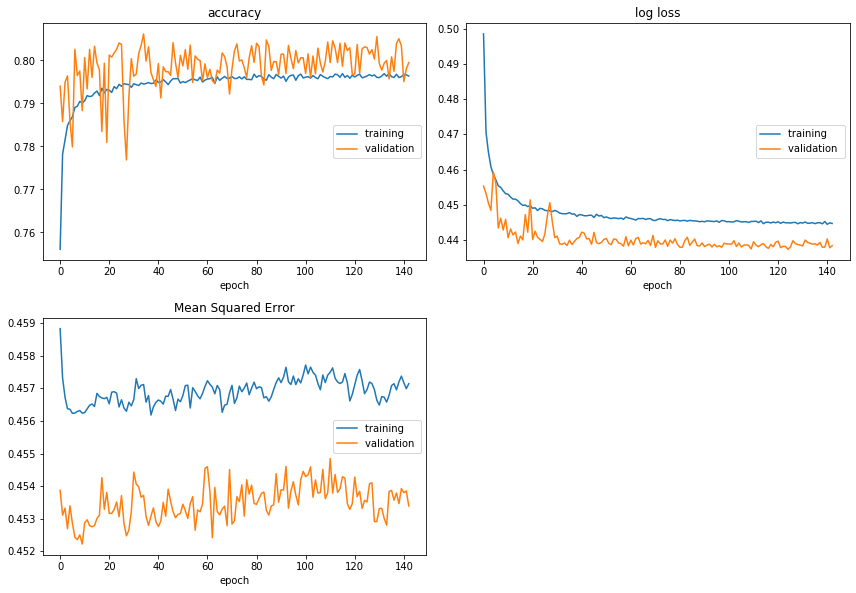

accuracy
	training         	 (min:    0.756, max:    0.797, cur:    0.796)
	validation       	 (min:    0.777, max:    0.806, cur:    0.800)
log loss
	training         	 (min:    0.444, max:    0.499, cur:    0.445)
	validation       	 (min:    0.437, max:    0.459, cur:    0.438)
Mean Squared Error
	training         	 (min:    0.456, max:    0.459, cur:    0.457)
	validation       	 (min:    0.452, max:    0.455, cur:    0.453)


In [ ]:
num_running_loss = 10

data_loader = {'train':train_loader, 'validation':valid_loader}

logs = {}
for epoch in range(1000):
    
    for phase in ['train', 'validation']:
        if phase == 'train':
            model.train()
        else:
            model.eval()
        
        prefix = ''
        if phase == 'validation':
            prefix = 'val_'
            
        running_loss = 0.0
        running_corrects = 0
        running_se = 0.0
        for i, batch in enumerate(data_loader[phase], 0):
            batch = [item.to(device) for item in batch]
            inputs, labels = batch
            # zero the parameter gradients
            if phase == 'train':
                optimizer.zero_grad()

            # forward + backward + optimize
            loss, output = model(inputs, labels)
            if phase == 'train':
                loss.backward()
                optimizer.step()

            # print statistics
            loss = loss.cpu().detach()
            output = output.cpu().detach()
            labels = labels.cpu().detach()
            _, y_pred = torch.max(output, 1)
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(y_pred == labels)
            running_se += torch.sum((nn.functional.softmax(output, dim=0)[:, 1] - labels)**2)
            
        epoch_loss = running_loss / len(data_loader[phase].dataset)
        logs[prefix + 'log loss'] = epoch_loss
        epoch_acc = running_corrects.float() / len(data_loader[phase].dataset)
        logs[prefix + 'accuracy'] = epoch_acc.item()
        epoch_mse = running_se.float() / len(data_loader[phase].dataset)
        logs[prefix + 'mse'] = epoch_mse.item()
        
    liveloss.update(logs)
    liveloss.draw()